<a href="https://colab.research.google.com/github/Idan-Alter/OU-22961-Deep-Learning/blob/main/22961_7_5_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install datasets

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import datasets as ds
import matplotlib.pyplot as plt

In [ ]:
src = "en"
tgt = "fr"
dataset = ds.load_dataset("tatoeba", lang1=src, lang2=tgt)

pairs_list = dataset["train"]["translation"]
total      = len(pairs_list)
src_sents_unfiltered = [x[src].split() for x in pairs_list]
tgt_sents_unfiltered = [x[tgt].split() for x in pairs_list]

MAX_length = 5
filter = lambda idx: len(src_sents_unfiltered[idx]) <= MAX_length and \
                     len(tgt_sents_unfiltered[idx]) <= MAX_length
mask = map(filter, range(total))
src_sents = [x for idx, x in enumerate(src_sents_unfiltered) if filter(idx)]
tgt_sents = [x for idx, x in enumerate(tgt_sents_unfiltered) if filter(idx)]

torch.manual_seed(0)
shuffle_idxs = torch.randperm(len(src_sents))
def shuffle(my_list):
  extract_one   = lambda x: my_list[shuffle_idxs[x]]
  shuffled_list = list(map(extract_one, range(len(my_list))))
  return shuffled_list
src_sents = shuffle(src_sents)
tgt_sents = shuffle(tgt_sents)

for idx in range(len(src_sents)):
  src_sents[idx].append("<END>")
  tgt_sents[idx] = ["<START>"]+tgt_sents[idx]+["<END>"]

from torchtext.vocab import build_vocab_from_iterator
src_vocab = build_vocab_from_iterator(src_sents, specials=["<UNK>", "<END>"])
src_vocab.set_default_index(0)
print(len(src_vocab))
tgt_vocab = build_vocab_from_iterator(tgt_sents, specials=["<UNK>", "<END>", "<START>"])
tgt_vocab.set_default_index(0)
print(len(tgt_vocab))

src_tokens = list(map(lambda x: torch.tensor(src_vocab(x)), src_sents))
tgt_tokens = list(map(lambda x: torch.tensor(tgt_vocab(x)), tgt_sents))


In [ ]:
START_Token = torch.tensor(tgt_vocab(["<START>"])[0])
END_Token   = torch.tensor(tgt_vocab(["<END>"])[0])
print(START_Token,END_Token)

tensor(2) tensor(1)


In [ ]:
A = [src_vocab.get_itos()[x.item()] for x in src_tokens[1]] 
B = [tgt_vocab.get_itos()[x.item()] for x in tgt_tokens[1]] 
print(A, B)

['It', 'was', 'too', 'hard.', '<END>'] ['<START>', 'Il', 'était', 'trop', 'dur.', '<END>']


#Full History Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, RNNlayers):
        super().__init__()
        self.src_embedding  = nn.Embedding(len(src_vocab),
                                           embed_dim)  
        self.rnn_stack      = nn.LSTM(embed_dim,                   
                                 hidden_dim,
                                 RNNlayers)  

    def forward(self, src_tokens):
      all_embeddings         = self.src_embedding(src_tokens)
      all_embeddings         = all_embeddings.unsqueeze(1)
      annotations, _= self.rnn_stack(all_embeddings)     #
      return annotations.squeeze()                       #

#Attention

In [ ]:
from pprint import pprint
values = ["woman", "man", "bicycle", "queen", "house"]
keys  = values
my_dict = dict(zip(keys,values))
pprint(my_dict)

{'bicycle': 'bicycle',
 'house': 'house',
 'man': 'man',
 'queen': 'queen',
 'woman': 'woman'}


In [ ]:
print(my_dict.get("woman"), my_dict.get("girl"))

woman None


In [ ]:
from torchtext.vocab import GloVe
glove_embedder = GloVe(name='6B',dim=50)
keys = glove_embedder.get_vecs_by_tokens(values)
print(keys.size(), keys.dtype)

torch.Size([5, 50]) torch.float32


In [ ]:
def soft_search(query, keys, values):
  dict_size      = len(values) 
  cos_similarity = torch.zeros(dict_size)
  q_norm         = query.norm()
  for idx in range(dict_size):
    dot                 = (query*keys[idx]).sum()
    k_norm              = keys[idx].norm()
    cos_similarity[idx] = dot/(q_norm*k_norm)
  best_match_idx = cos_similarity.argmax()
  return values[best_match_idx], cos_similarity

In [ ]:
queries = ["king", "castle", "car", "girl", "animal"]
sim_matrix = torch.zeros(len(queries),len(values))
for idx,q in enumerate(queries):
  q_embedded = glove_embedder.get_vecs_by_tokens(q)
  search_result, cos_similarity = soft_search(q_embedded, keys, values)
  sim_matrix[idx,:] = cos_similarity
  print("", q, search_result, cos_similarity, sep="\n")


king
queen
tensor([0.4113, 0.5309, 0.0535, 0.7839, 0.5228])

castle
queen
tensor([0.1891, 0.2858, 0.0292, 0.5805, 0.5555])

car
bicycle
tensor([0.5011, 0.5797, 0.7560, 0.2883, 0.4729])

girl
woman
tensor([0.9065, 0.7908, 0.3204, 0.5878, 0.4126])

animal
man
tensor([0.5051, 0.5233, 0.3188, 0.2353, 0.3400])


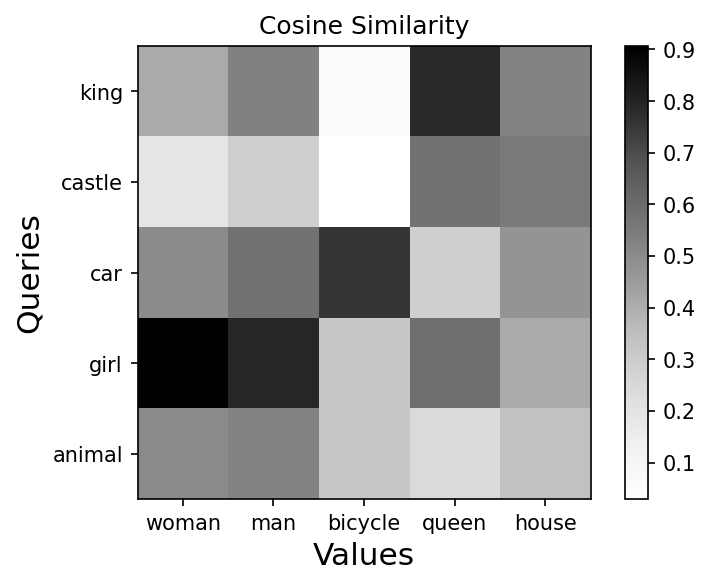

In [ ]:
def plot_attention(matrix,queries,values):
  plt.figure(dpi=150)
  plt.imshow(matrix,cmap="Greys")
  plt.colorbar()
  plt.xticks(ticks=range(len(values)), labels=values, size=10);
  plt.xlabel("Values",size=15)
  plt.yticks(ticks=range(len(queries)), labels=queries, size=10);
  plt.ylabel("Queries",size=15);
plot_attention(sim_matrix, queries, values)
plt.title("Cosine Similarity");

#Dot Product Attention

In [ ]:
def dot_attention(q, K, V):
  dict_size  = K.size(0) 
  similarity = torch.zeros(dict_size)
  for idx in range(dict_size):
    similarity[idx] = (q * K[idx,:]).sum()
  attn_weights = F.softmax(similarity, dim=0)
  weighted_V   = torch.zeros_like(V)
  for idx in range(dict_size):
    weighted_V[idx,:] = attn_weights[idx] * V[idx,:]
  output = weighted_V.sum(dim=0)
  return output, attn_weights

In [ ]:
src_words  = ["woman", "man", "bicycle", "queen", "house"]
values     = glove_embedder.get_vecs_by_tokens(src_words)
keys       = values
query      = glove_embedder.get_vecs_by_tokens("king")
search_result, attn_weights = dot_attention(query, keys, values)
print(search_result.size(), search_result.dtype)
print(attn_weights)

torch.Size([50]) torch.float32
tensor([7.0899e-05, 9.9381e-04, 1.3337e-09, 9.9831e-01, 6.2366e-04])


['woman', 'man', 'bicycle', 'queen', 'house']

king
tensor([7.0899e-05, 9.9381e-04, 1.3337e-09, 9.9831e-01, 6.2366e-04])

castle
tensor([1.3843e-05, 1.6120e-04, 9.1942e-08, 6.9318e-01, 3.0664e-01])

car
tensor([3.1750e-03, 1.3041e-02, 9.8336e-01, 1.8839e-06, 4.1913e-04])

girl
tensor([9.9414e-01, 5.8476e-03, 3.3290e-09, 1.1873e-05, 6.3629e-08])

animal
tensor([5.8669e-01, 4.0910e-01, 1.2610e-03, 1.8631e-04, 2.7535e-03])


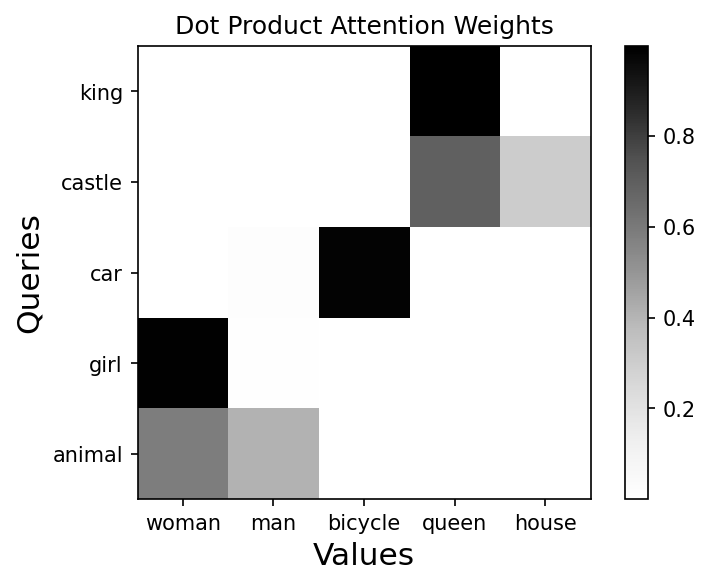

In [ ]:
print(src_words)
attn_matrix = torch.zeros(len(queries), len(src_words))
for idx, q in enumerate(queries):
  q_embedded = glove_embedder.get_vecs_by_tokens(q)
  output, attn_weights = dot_attention(q_embedded, keys, keys)
  attn_matrix[idx,:]   = attn_weights
  print("", q, attn_weights, sep="\n")
plot_attention(attn_matrix, queries, src_words)
plt.title("Dot Product Attention Weights");

In [ ]:
def dot_attention_vectorized(q, k, v):
  similarity   = (q.reshape(1,-1) @ k.T)
  attn_weights = F.softmax(similarity, dim=1)
  weighted_v   = attn_weights.reshape(-1,1) * v
  output       = weighted_v.sum(dim=0)
  return output, attn_weights

In [ ]:
q = "truck"
q_embedded = glove_embedder.get_vecs_by_tokens(q)
output, attn_weights   = dot_attention_vectorized(q_embedded, keys, keys)
output2, attn_weights2 = dot_attention(q_embedded, keys, keys)
print((output - output2).norm() / output.norm())
print((attn_weights - attn_weights2).norm() / attn_weights.norm()) #should be ~0

tensor(1.6622e-09)
tensor(2.2921e-09)


In [ ]:
dot_attention = dot_attention_vectorized

#Attention Decoder

In [ ]:
class ContextRNNCell(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_linear = nn.Linear(in_features = hidden_dim,
                                      out_features = hidden_dim)
        self.input_linear  = nn.Linear(in_features = embed_dim,
                                      out_features = hidden_dim)
        self.ctxt_linear   = nn.Linear(in_features = hidden_dim,
                                      out_features = hidden_dim)
        self.activation    = nn.Tanh()
    def forward(self, one_embedded_token, hidden_state, context):
        Z1        = self.input_linear(one_embedded_token)
        Z2        = self.hidden_linear(hidden_state)
        Z3        = self.ctxt_linear(context)
        Y         = Z1 + Z2 + Z3
        new_state = self.activation(Y)
        return new_state

In [ ]:
#Compare to DecoderRNNCell from 7_4
class AttnDecoderRNNCell(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_state  = torch.zeros(hidden_dim)
        self.RNNcell       = ContextRNNCell(embed_dim,        #
                                            hidden_dim)
        self.output_linear = nn.Linear(in_features=hidden_dim,
                                  out_features=len(tgt_vocab))
        self.logsoftmax    = nn.LogSoftmax(dim=0)
        
    def forward(self, one_embedded_token, attn_context):
        new_state           = self.RNNcell(one_embedded_token,
                                           self.hidden_state,
                                           attn_context)      #
        tgt_token_scores   = self.output_linear(new_state)
        tgt_token_logprobs = self.logsoftmax(tgt_token_scores)
        self.hidden_state  = new_state 
        return tgt_token_logprobs

In [ ]:
class AttnDecoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim):
        super().__init__()
        self.hidden_dim     = hidden_dim
        self.tgt_embedding  = nn.Embedding(len(tgt_vocab),
                                           embed_dim)  
        self.RNNcell        = AttnDecoderRNNCell(embed_dim,
                                                 hidden_dim)  
        self.attn_layer     = dot_attention
    def forward(self, annotations, tgt_tokens):
      self.RNNcell.hidden_state = torch.zeros(self.hidden_dim)
      keys   = annotations
      values = annotations 
      translated_tokens = [START_Token]
      sentence_loss = 0
      for idx in range(len(tgt_tokens)-1):
        previous_token  = translated_tokens[idx]
        embedded_token  = self.tgt_embedding(previous_token)
        query           = self.RNNcell.hidden_state
        attn_context,_  = self.attn_layer(query, keys, values)  #
        logprobs        = self.RNNcell(embedded_token,
                                       attn_context)
        predicted_token = logprobs.argmax()
        translated_tokens.append(predicted_token.detach())
        
        correct_token   = tgt_tokens[idx+1]
        token_loss      = -logprobs[correct_token]
        sentence_loss  += token_loss

        if predicted_token == END_Token:
          break
      return translated_tokens, sentence_loss

In [ ]:
class Translator(nn.Module):
      def __init__(self, embed_dim, hidden_dim, encoder_layers):
        super().__init__()
        self.encoder = Encoder(embed_dim,
                               hidden_dim,
                               encoder_layers)
        self.decoder = AttnDecoder(embed_dim, hidden_dim)
      def forward(self, src_tokens, tgt_tokens):
        annotations = self.encoder(src_tokens)
        return self.decoder(annotations, tgt_tokens)

#Training

In [ ]:
def iterate_one_pair(src_tokens, tgt_tokens):
    model.train()  
    optimizer.zero_grad()
    output, loss = model(src_tokens, tgt_tokens)
    loss.backward()
    optimizer.step()
    return loss.detach()

In [ ]:
model     = Translator(50,50,2)
optimizer = torch.optim.AdamW(model.parameters())

In [ ]:
#overfit a small batch to check if learning _can_ occur
num_samples, epochs = 10, 200
for epoch in range(epochs):
  batch_loss_agg = torch.tensor([0.])
  for idx in range(num_samples):
    batch_loss_agg += iterate_one_pair(src_tokens[idx], tgt_tokens[idx])
  epoch_loss = batch_loss_agg / num_samples
  if epoch % 20 == 0:
    print("Epoch", epoch, " loss:", epoch_loss.item())

Epoch 0  loss: 51.21791458129883
Epoch 20  loss: 9.8264799118042
Epoch 40  loss: 8.278763771057129
Epoch 60  loss: 6.569948673248291
Epoch 80  loss: 4.590009689331055
Epoch 100  loss: 1.8273242712020874
Epoch 120  loss: 1.0401173830032349
Epoch 140  loss: 0.672622799873352
Epoch 160  loss: 0.47169360518455505
Epoch 180  loss: 0.34629207849502563


In [ ]:
with torch.no_grad():
  for idx in range(num_samples):
    a, b = model(src_tokens[idx], tgt_tokens[idx])
    predicted_itos = [tgt_vocab.get_itos()[x.item()] for x in a] 
    ground_truth   = [tgt_vocab.get_itos()[x.item()] for x in tgt_tokens[idx]] 
    print(predicted_itos, ground_truth)

['<START>', 'Je', 'pense', 'que', 'ça', 'aide.', '<END>'] ['<START>', 'Je', 'pense', 'que', 'ça', 'aide.', '<END>']
['<START>', 'Il', 'était', 'trop', 'dur.', '<END>'] ['<START>', 'Il', 'était', 'trop', 'dur.', '<END>']
['<START>', 'Écrivez', 'votre', 'nom', 'en', 'majuscules.', '<END>'] ['<START>', 'Écrivez', 'votre', 'nom', 'en', 'majuscules.', '<END>']
['<START>', 'Où', 'séjournes-tu', '?', '<END>'] ['<START>', 'Où', 'séjournes-tu', '?', '<END>']
['<START>', 'Elle', 'entrouvrit', 'la', 'porte.', '<END>'] ['<START>', 'Elle', 'entrouvrit', 'la', 'porte.', '<END>']
['<START>', 'Je', 'ne', 'suis', 'pas', 'intimidée.', '<END>'] ['<START>', 'Je', 'ne', 'suis', 'pas', 'intimidée.', '<END>']
['<START>', "C'est", 'gentil.', '<END>'] ['<START>', "C'est", 'gentil.', '<END>']
['<START>', 'Personne', 'ne', 'le', 'saura.', '<END>'] ['<START>', 'Personne', 'ne', 'le', 'saura.', '<END>']
['<START>', 'Ne', 'va', 'pas', 'là.', '<END>'] ['<START>', 'Ne', 'va', 'pas', 'là.', '<END>']
['<START>', 'La', 

In [ ]:
with torch.no_grad():
  for idx in range(num_samples, num_samples+5):
    a, b = model(src_tokens[idx], tgt_tokens[idx])
    predicted_itos = [tgt_vocab.get_itos()[x.item()] for x in a] 
    ground_truth   = [tgt_vocab.get_itos()[x.item()] for x in tgt_tokens[idx]] 
    print(predicted_itos, ground_truth)

['<START>', 'Où', 'séjournes-tu', '?', '<END>'] ['<START>', 'Nous', 'avons', 'toutes', 'nos', 'secrets.', '<END>']
['<START>', 'Je', 'ne', 'suis', 'pas'] ['<START>', "J'aime", 'cette', 'chambre.', '<END>']
['<START>', 'Écrivez', 'votre', 'nom', 'en', 'majuscules.', '<END>'] ['<START>', 'Nous', 'ne', 'pouvons', 'pas', "l'aider.", '<END>']
['<START>', 'Où', 'séjournes-tu', '?', '<END>'] ['<START>', 'Ils', 'sont', 'nos', 'invités.', '<END>']
['<START>', 'Où', 'séjournes-tu', '?', '<END>'] ['<START>', 'Voulez-vous', 'coucher', 'avec', 'moi', '?', '<END>']
